# Pulse-shaping for Linearly Modulated Signals

This notebook focuses on pulse-shaping for linearly modulated signal. We will see the impact that pulse-shaping has on the spectrum of the modulated signals. The pulse shape also determines if adjacent symbols interfere with each other; the Nyquist criterion provides a simple condition that guarantees that no such interference occurs. Practical considerations for the selection of pulse shapes are illustrated. 

<a href="https://colab.research.google.com/github/bepepa/digital_comms/blob/master/030_pulse_shaping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> (Executable notebook)

<a href="https://nbviewer.org/format/slides/github/bepepa/digital_comms/blob/main/030_pulse_shaping.ipynb"><img src="https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.svg" alt="Render nbviewer" /> </a> (read-only, slides view)

In [1]:
## Boilerplate instructions for importing NumPy and Matplotlib
# Import NumPy
import numpy as np

# To plot pretty figures, use matplotlib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## Linearly Modulated Signals and their Spectra

A linearly modulated signal $s(t)$ is constructed from  information symbols $s_n$ drawn from a constellation $\cal A$ and  pulse shape $p(t)$:
$$
    s(t) = \sum_n s_n \cdot p(t-nT).
$$

Usually, the information symbols $s_n$ have zero mean ($\text{\bf E}[s_n]=0$) and are uncorrelated
$$
\text{\bf E}[s_n s_m^*] = \begin{cases}
    \sigma_s^2 & \text{when $n=m$}\\
    0 & \text{when $n \neq m$,}
\end{cases}
$$
where $\sigma_s^2 = \text{\bf E}[|s_n|^2]$ is the variance of the information symbols. Recall that it is common to normalize the constellation such that $\sigma_s^2=1$.

Then, Power Spectral Density (PSD) of the linearly modulated signal $s(t)$ is given by
$$
    S(f) = \frac{\sigma^2}{T} |P(f)|^2,
$$
wher $P(f)$ is the Fourier Transform of $p(t)$.

### Example: recatanglar and triangular pulse

Let $p(t)$ be a triangular pulse of width $T$, i.e.,
$$
p(t) = \begin{cases}
    2t & \text{for $0 \leq t <T/2$} \\
    2(T-t) & \text{for $T/2 \leq < T$} \\
    0 & \text{else.}
\end{cases}
$$

The Fourier transform of $p(t)$ is equal to
$$
P(f) = \frac{T}{2} \text{sinc}^2(\frac{\pi}{2}fT)
$$

And, the PSD of a linearly, modulated signal with these pulse is 
$$
S(f) = \frac{\sigma^2 T}{4} \text{sinc}^4(\frac{\pi}{2}fT)
$$

Similarly, for a rectangular pulse of duration $T$,
$$
p(t) = \begin{cases}
    1 & \text{for $0 \leq t <T$}\\
    0 & \text{else}
    \end{cases}
$$
the PSD equals
$$
S(f) = \sigma^2 T \text{sinc}^2(\pi fT).
$$


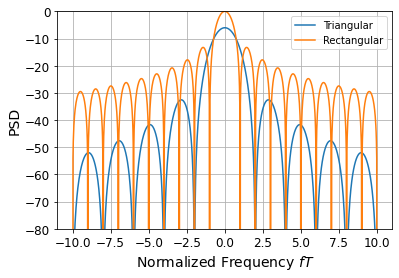

In [10]:
# plot PSD of triangular pulse
sigma_sq = 1
T = 1
fT = np.linspace(-10, 10, 1001)
S_t = sigma_sq/4 * (np.sinc(fT/2))**4  # note: np.sinc(x) = sin(pi*x)/(pi*x)
S_r = sigma_sq * (np.sinc(fT))**2     # note: np.sinc(x) = sin(pi*x)/(pi*x)


plt.plot(fT, 10*np.log10(S_t))
plt.plot(fT, 10*np.log10(S_r))

plt.ylim([-80,0])
plt.grid()

plt.xlabel('Normalized Frequency $fT$')
plt.ylabel('PSD')

plt.legend(['Triangular', 'Rectangular'])

plt.show()

Both pulses have a clearly defined main-lobe and multiple sidelobes.

The rectangular pulse has a narrower mainlobe (two-sided width: $2/T$). The two-sided width for the triangular pulse is $4/T$.

The sildelobes of the triangular pulse decay faster ($\sim 1/f^4$) than those of the rectangular pulse ($\sim 1/f^2$)

### Measures of Bandwidth

To quantify the bandwidth occupied by a linearly modulated signal, it is useful to define metrics that capture bandwidth in a single quantity.
The following metrics are commonly used for this purpose:

* **Zero-to-Zero Bandwidth:** is the width between the two zeros on either side of the main-lobe. This is easy to measure. But, not all pulse shapes have spectra zeros (e.g., a Gaussian pulse).

* **3dB Bandwidth:** is the width between the frequencies where the PSD has dropped 3dB from its peak. I.e., the two-sided bandwidth $B_{3dB}$ satisfies 
$$
S(B_{3dB}/2) = 0.5 \cdot S(0).
$$ 
This is again easy to measure. The resulting metric is often too optimistic and does not account for the sidelobes.

* **Fractional Energy Containment Bandwidth:** is defined as the two-sided bandwidth $B_a$ that contains a fraction $0 < a < 1$ of the energy of the entire signal. Specifically, $B_a$ is defined by the relationship
$$
\int_{-B_a/2}^{B_a/2} S(f) \, df = a \cdot \int_{-\infty}^{\infty} S(f) \, df.
$$
This metric must usually be evaluated numerically. However, it provides a comprehensive measure of bandwidth, including the sidelobe roll-off. Useful values for $a$ are $a=0.99$ and $a=0.9$.

